# Auto encoder with classification in Deep Learning

In [ ]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
!pip install -q torchmetrics
from torchmetrics.classification import MulticlassAccuracy

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
# device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
# setup training dataset
train_data = datasets.FashionMNIST(
    root = 'data',
    train = True,
    download = True,
    transform = ToTensor(),
    target_transform = None
)

# setup testing data
test_data = datasets.FashionMNIST(
    root = 'data',
    train = False,
    download = True,
    transform = ToTensor()
)

In [ ]:
class_name = train_data.classes
class_name

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
index_idx = train_data.class_to_idx
index_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

Image: torch.Size([1, 28, 28])


Text(0.5, 1.0, '9')

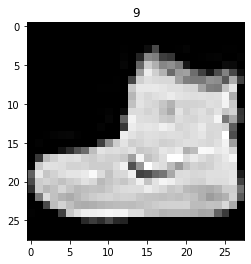

In [ ]:
image, label = train_data[0]
print(f"Image: {image.shape}")
plt.imshow(image.squeeze(), cmap = 'gray')
plt.title(label)
# image

Text(0.5, 1.0, '9')

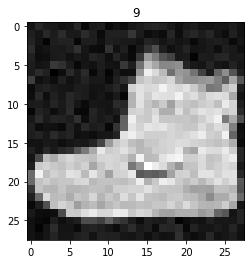

In [ ]:
# add noise in image
image1 = image + 0.05*torch.randn_like(image)
plt.imshow(image1.squeeze(), cmap = 'gray')
plt.title(label)

DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7f229fe25910>, <torch.utils.data.dataloader.DataLoader object at 0x7f229fe25280>
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [ ]:
# Auto ancode model
class AutoEncoder(nn.Module):
  def __init__(self, input_units : int, output_units: int):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Linear(in_features = input_units, out_features = output_units),
        nn.Sigmoid(),
        nn.Linear(in_features = output_units, out_features = output_units),
        nn.Sigmoid(),
        nn.Linear(in_features = output_units, out_features = output_units),
        nn.Sigmoid(),
        nn.Linear(in_features = output_units, out_features = output_units),
        nn.Sigmoid()
    )

    self.decoder = nn.Sequential(
        nn.Linear(in_features = output_units, out_features = output_units),
        nn.Sigmoid(),
        nn.Linear(in_features = output_units, out_features = output_units),
        nn.Sigmoid(),
        nn.Linear(in_features = output_units, out_features = output_units),
        nn.Sigmoid(),
        nn.Linear(in_features = output_units, out_features = input_units),
        nn.Sigmoid()
    )

  def encode(self, x):
    return self.encoder(x.view(-1, 784))

  def decode(self, z):
    return self.decoder(z)

  def forward(self, x):
    z = self.encode(x)
    return self.decode(z)



In [ ]:
# auto_model.state_dict()

## train and test loop

In [ ]:
from tqdm.auto import tqdm

# train loop
def train_loop(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
  
  # train
  train_loss = 0
  # train_loss_loop = []
  # train_loss_lst = []
  for batch, (train_data, _) in enumerate(dataloader):

    # add noice in image (gaussian noise)
    data = train_data + 0.2*torch.randn_like(train_data)
    # print(x_train.shape)

    if device == 'cuda':
      # x_train, y_train = x_train.to(device), y_train.to(device)
      train_data = train_data.to(device)
      data = data.to(device)

    model.train()

    # 1. Forward
    train_data = train_data.reshape(-1, 784)
    pred = model(data)

    # 2. Loss and Accuracy
    loss = loss_fn(pred, train_data)
    train_loss += loss
    # train_loss_lst.append(loss.item())

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. Backward
    loss.backward()

    # 5. optimizer step
    optimizer.step()

  train_loss /= len(dataloader)
  # train_loss_loop.append(train_loss)
  

  # print(f"Train Loss: {train_loss:.4f}")
  return train_loss

# test loop
def test_loop(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = device):
  
  test_loss = 0
  # test_loss_loop = []
  # test_loss_lst = []
  # pass model for evaluation
  model.eval()
  with torch.inference_mode():
    for i, (test_data, _) in enumerate(dataloader):
      if device == 'cuda':
        # x_test, y_test = x_test.to(device), y_test.to(device)
        test_data = test_data.to(device)

      # 1. Forward
      test_data = test_data.reshape(-1, 784)
      test_pred = model(test_data)

      # 2. Loss
      loss = loss_fn(test_pred, test_data)

      test_loss += loss

      # test_loss_lst.append(loss)

    test_loss /= len(dataloader)
    # test_loss_loop.append(test_loss)

  # print(f"Test Loss: {test_loss:.4f}")
  return test_loss


In [ ]:
# len(train_dataloader)*BATCH_SIZE

## loss and optimizer for encoer class

In [ ]:
torch.manual_seed(64)
torch.cuda.manual_seed(64)
auto_model = AutoEncoder(input_units = 784, output_units = 32).to(device)
auto_model

# loss
loss_fn = nn.MSELoss()
# loss_fn = nn.L1Loss()

# optimizer
optimizer = torch.optim.Adam(params = auto_model.parameters(), lr = 0.01)

In [ ]:
# train model
epoches = 32

torch.manual_seed(42)
torch.cuda.manual_seed(42)


train = []
test = []
for epoch in tqdm(range(epoches)):

  train_loss = train_loop(model = auto_model, dataloader = train_dataloader,
                          loss_fn = loss_fn, optimizer = optimizer, device = device)
  
  test_loss = test_loop(model = auto_model, dataloader = test_dataloader,
                        loss_fn = loss_fn, device = device)
  
  print(f"Epoch: {epoch+1} Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")


  train.append(train_loss.item())
  test.append(test_loss.item())



  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.0614 | Test Loss: 0.0512
Epoch: 2 Train Loss: 0.0506 | Test Loss: 0.0507
Epoch: 3 Train Loss: 0.0485 | Test Loss: 0.0475
Epoch: 4 Train Loss: 0.0421 | Test Loss: 0.0377
Epoch: 5 Train Loss: 0.0374 | Test Loss: 0.0350
Epoch: 6 Train Loss: 0.0357 | Test Loss: 0.0341
Epoch: 7 Train Loss: 0.0335 | Test Loss: 0.0322
Epoch: 8 Train Loss: 0.0320 | Test Loss: 0.0309
Epoch: 9 Train Loss: 0.0313 | Test Loss: 0.0302
Epoch: 10 Train Loss: 0.0307 | Test Loss: 0.0304
Epoch: 11 Train Loss: 0.0302 | Test Loss: 0.0296
Epoch: 12 Train Loss: 0.0296 | Test Loss: 0.0284
Epoch: 13 Train Loss: 0.0297 | Test Loss: 0.0323
Epoch: 14 Train Loss: 0.0303 | Test Loss: 0.0288
Epoch: 15 Train Loss: 0.0283 | Test Loss: 0.0272
Epoch: 16 Train Loss: 0.0274 | Test Loss: 0.0265
Epoch: 17 Train Loss: 0.0270 | Test Loss: 0.0266
Epoch: 18 Train Loss: 0.0267 | Test Loss: 0.0266
Epoch: 19 Train Loss: 0.0263 | Test Loss: 0.0259
Epoch: 20 Train Loss: 0.0261 | Test Loss: 0.0257
Epoch: 21 Train Loss: 0.0259 

In [ ]:
## loss vs epoch plot
def loss_plot(train, test):
  plt.figure(figsize = (10,7))
  # plt.plot(range(1, epoches*(len(train_dataloader)*BATCH_SIZE) + 1), train)
  plt.plot(range(len(train)),train, label = "Train Loss")
  plt.plot(range(len(test)),test, label = "Test Loss")
  plt.xlabel("Epoches")
  plt.ylabel("Loss")
  plt.title("Loss")
  plt.legend()
  plt.show()

In [ ]:
# print(train[:10])
# train loss plot
# plt.figure(figsize = (10,7))
# plt.plot(range(1, epoches*(len(train_dataloader)*BATCH_SIZE) + 1), train)
# plt.plot(range(len(train)),train)
# plt.plot(range(len(test)),test)
# plt.xlabel("Epoches")
# plt.ylabel("Loss")
# plt.title("Loss")
# plt.show()

# test loss plot
# plt.figure(figsize = (10,7))
# # plt.plot(range(1, epoches*(len(test_dataloader)*BATCH_SIZE)+ 1), test)
# plt.plot(range(len(test)),test)
# plt.xlabel("Epoches")
# plt.ylabel("Loss")
# plt.title("Tran Loss")
# plt.show()

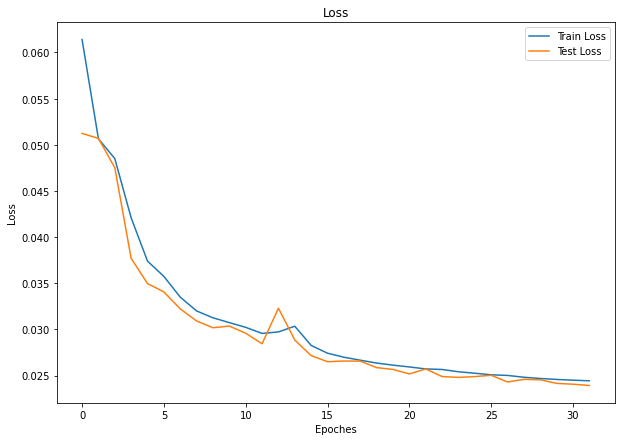

In [ ]:
loss_plot(train, test)

## Autoencoder Regenerate

In [ ]:
# show image after auto-encoder
def imshow(data, label):
  torch.manual_seed(64)
  fig = plt.figure(figsize = (11,4))
  rows, cols = 2, 5
  for i in range(1, rows*cols +1):
    random_idx = torch.randint(0, len(data), size = [1]).item()
    image = data[random_idx]
    fig.add_subplot(rows, cols, i)
    # print(label)
    plt.imshow(image.squeeze(), cmap = 'gray')
    # plt.imshow(data)
    # plt.title(class_name[label[random_idx]])
    plt.axis(False)


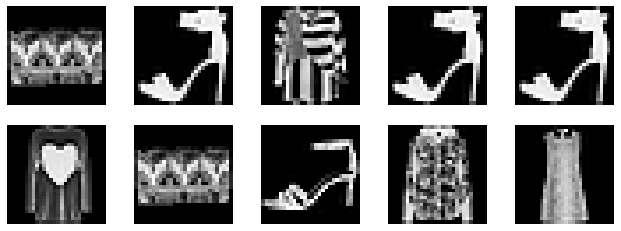

In [ ]:
torch.manual_seed(64)

for (image, label) in test_dataloader:
  pass
imshow(image, label)

In [ ]:
# image2 = image + 0.2*torch.randn_like(image)
# plt.imshow(image2[13].squeeze(), cmap = 'gray')

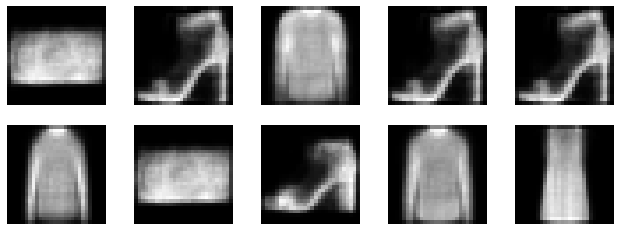

In [ ]:
# recreation of image
auto_model.eval()
with torch.inference_mode():
  image1 = image + 0.2*torch.randn_like(image)
  # torch.manual_seed(64)
  # idx = torch.randint(0, len(image1), size = [1]).item()
  # plt.imshow(image1[idx].squeeze(), cmap = 'gray')
  image1 = image1.to(device)
  recreate = auto_model(image1)

imshow(recreate.view(-1, 1, 28, 28).cpu(), label)

## t-SNE plot for Autoencoder

In [ ]:
imgs = []
labels = []
num = 0

with torch.inference_mode():
  for img, label in test_dataloader:
    enimg = auto_model.encode(img.to(device).view(-1, 784))
    imgs.append(enimg.cpu())
    labels.append(label)
    num += len(img)
    if num >= 1000:
      break

# conver list to tensor
imgs_tensor = torch.cat(imgs)
label_tensor = torch.cat(labels)

In [ ]:
imgs_tensor.shape

torch.Size([1024, 32])

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


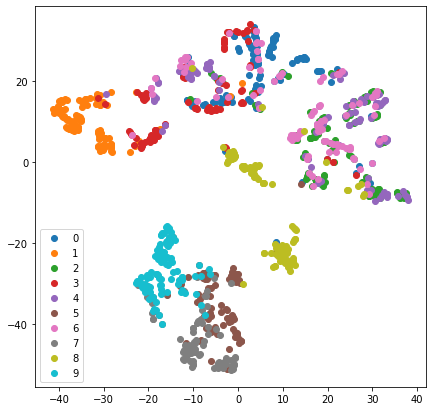

In [ ]:
tsne = TSNE(n_components = 2, random_state = 64)
tsne_model = tsne.fit_transform(imgs_tensor)

fig, ax = plt.subplots(figsize=(7, 7))
for l in np.unique(label_tensor):
    ix = np.where(label_tensor == l)
    ax.scatter(tsne_model[:,0][ix], tsne_model[:,1][ix],  label = l)
ax.legend()
plt.show()

## FC Models

In [ ]:
# build base model (FC1)
class FashionMNISTModelFC1(nn.Module):
  def __init__(self, input_units: int, output_units: int, hidden_units: int):
    super().__init__()
    # # self.encoder = 
    # self.encoder = nn.Sequential(
    #     nn.Linear(in_features = input_units, out_features = hidden_units),
    #     nn.Sigmoid(),
    #     nn.Linear(in_features = hidden_units, out_features = hidden_units),
    #     nn.Sigmoid(),
    #     nn.Linear(in_features = hidden_units, out_features = hidden_units),
    #     nn.Sigmoid(),
    #     nn.Linear(in_features = hidden_units, out_features = hidden_units),
    #     nn.Sigmoid()
    # )

    self.layer_stack = nn.Sequential(
        # nn.Flatten(),
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        nn.Sigmoid(),
        nn.Linear(in_features = hidden_units, out_features = output_units),
        nn.Sigmoid()
    )

    # self.decoder = nn.Sequential(
    #     nn.Linear(in_features = output_units, out_features = hidden_units),
    #     nn.Sigmoid(),
    #     nn.Linear(in_features = hidden_units, out_features = hidden_units),
    #     nn.Sigmoid(),
    #     nn.Linear(in_features = hidden_units, out_features = hidden_units),
    #     nn.Sigmoid(),
    #     nn.Linear(in_features = hidden_units, out_features = input_units),
    #     nn.Sigmoid()
    # )
    
  def forward(self, x):
    x = auto_model.encode(x)
    return self.layer_stack(x)

  # def decode(self, x):
  #   return self.decoder(x)

# torch.manual_seed(64)
# torch.cuda.manual_seed(64)
# fc1_model = FashionMNISTModelFC1(input_units = 784, output_units = len(class_name), hidden_units = 20)
# fc1_model

In [ ]:
# fc1_model.state_dict()

In [ ]:
# build base model (FC3)
class FashionMNISTModelFC3(nn.Module):
  def __init__(self, input_units: int, output_units: int, hidden_units: int):
    super().__init__()
    # self.encoder = nn.Sequential(
    #     nn.Linear(in_features = input_units, out_features = hidden_units),
    #     nn.Sigmoid(),
    #     nn.Linear(in_features = hidden_units, out_features = hidden_units),
    #     nn.Sigmoid(),
    #     nn.Linear(in_features = hidden_units, out_features = hidden_units),
    #     nn.Sigmoid(),
    #     nn.Linear(in_features = hidden_units, out_features = hidden_units),
    #     nn.Sigmoid()
    # )
    
    self.layer_stack = nn.Sequential(
        # nn.Flatten(),
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        nn.Sigmoid(),
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        nn.Sigmoid(),
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        nn.Sigmoid(),
        nn.Linear(in_features = hidden_units, out_features = output_units),
        nn.Sigmoid()
    )

    # self.decoder = nn.Sequential(
    #     nn.Linear(in_features = output_units, out_features = hidden_units),
    #     nn.Sigmoid(),
    #     nn.Linear(in_features = hidden_units, out_features = hidden_units),
    #     nn.Sigmoid(),
    #     nn.Linear(in_features = hidden_units, out_features = hidden_units),
    #     nn.Sigmoid(),
    #     nn.Linear(in_features = hidden_units, out_features = input_units),
    #     nn.Sigmoid()
    # )
    
  def forward(self, x):
    x = auto_model.encode(x)
    return self.layer_stack(x)

  # def decode(self, x):
  #   return self.decoder(x)


In [ ]:
# fc3_model.state_dict()

## train and test loop for FC

In [ ]:
from tqdm.auto import tqdm

# train loop
def train_loop(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  
  # train
  train_loss, train_acc = 0, 0
  for batch, (x_train, y_train) in enumerate(dataloader):

    x_train, y_train = x_train.to(device), y_train.to(device)
    

    # data = x_train + 0.2*torch.randn_like(x_train)
    # x_auto = auto_model.encode(x_train)
    model.train()
    # x_auto = auto_model.encode(x_train)

    # 1. Forward
    x_train = x_train.reshape(-1, 784).to(device)
    y_pred = model(x_train)

    # 2. Loss and Accuracy
    loss = loss_fn(y_pred, y_train)
    train_loss += loss
    # train_acc += accuracy_fn(y_train, torch.softmax(y_pred, dim = 1).argmax(dim = 1))
    train_acc += accuracy_fn(y_train, torch.argmax(y_pred, dim = 1))

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. Backward
    loss.backward()

    # 5. optimizer step
    optimizer.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  # print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
  return train_loss, train_acc

# test loop
def test_loop(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  
  test_loss, test_acc = 0, 0
  # pass model for evaluation
  model.eval()
  with torch.inference_mode():
    for x_test, y_test in dataloader:

      x_test, y_test = x_test.to(device), y_test.to(device)

      # 1. Forward
      # x_test_auto = auto_model.encode(x_test)
      x_test = x_test.reshape(-1, 784)
      test_pred = model(x_test)

      # 2. Loss
      test_loss += loss_fn(test_pred, y_test)
      # test_acc += accuracy_fn(y_test, torch.softmax(test_pred, dim = 1).argmax(dim = 1))
      test_acc += accuracy_fn(y_test, torch.argmax(test_pred, dim = 1))

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  # print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

  return test_loss, test_acc

## train FC model

### FC 1

In [ ]:
# train model

torch.manual_seed(64)
torch.cuda.manual_seed(64)
fc1_model = FashionMNISTModelFC1(input_units = 784, output_units = len(class_name), hidden_units = 32).to(device)
print(fc1_model)

# loss and optimizer
# loss
loss_fn = nn.CrossEntropyLoss()

# optimizer
fc1_optimizer = torch.optim.Adam(params = fc1_model.parameters(), lr = 0.01)
# fc3_optimizer = torch.optim.SGD(params = fc3_model.parameters(), lr = 0.1)

# accuracy
accuracy_fn = MulticlassAccuracy(num_classes = len(class_name)).to(device)

epoches = 10

torch.manual_seed(64)
torch.cuda.manual_seed(64)

train = []
test = []
for epoch in tqdm(range(epoches)):

  train_loss, train_acc = train_loop(model = fc1_model, dataloader = train_dataloader,
                                     loss_fn = loss_fn, optimizer = fc1_optimizer,
                                     accuracy_fn = accuracy_fn, device = device)
  
  test_loss, test_acc = test_loop(model = fc1_model, dataloader = test_dataloader, 
                                  loss_fn = loss_fn, accuracy_fn = accuracy_fn, device = device)
  
  print(f"Epoch: {epoch+1} Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

  train.append(train_loss.item())
  test.append(test_loss.item())


FashionMNISTModelFC1(
  (layer_stack): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=10, bias=True)
    (3): Sigmoid()
  )
)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 1.7078 | Train Acc: 0.59% | Test Loss: 1.6432 | Test Acc: 0.67%
Epoch: 2 Train Loss: 1.6319 | Train Acc: 0.68% | Test Loss: 1.6327 | Test Acc: 0.68%
Epoch: 3 Train Loss: 1.6258 | Train Acc: 0.68% | Test Loss: 1.6298 | Test Acc: 0.68%
Epoch: 4 Train Loss: 1.6231 | Train Acc: 0.68% | Test Loss: 1.6288 | Test Acc: 0.67%
Epoch: 5 Train Loss: 1.6217 | Train Acc: 0.68% | Test Loss: 1.6286 | Test Acc: 0.67%
Epoch: 6 Train Loss: 1.6205 | Train Acc: 0.68% | Test Loss: 1.6271 | Test Acc: 0.68%
Epoch: 7 Train Loss: 1.6197 | Train Acc: 0.68% | Test Loss: 1.6261 | Test Acc: 0.67%
Epoch: 8 Train Loss: 1.6193 | Train Acc: 0.68% | Test Loss: 1.6253 | Test Acc: 0.67%
Epoch: 9 Train Loss: 1.6187 | Train Acc: 0.69% | Test Loss: 1.6254 | Test Acc: 0.68%
Epoch: 10 Train Loss: 1.6182 | Train Acc: 0.69% | Test Loss: 1.6240 | Test Acc: 0.67%


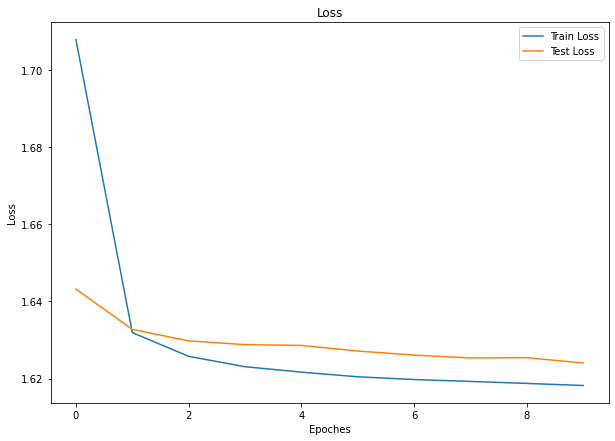

In [ ]:
# loss plot
loss_plot(train, test)

### FC 1 Model Recreation

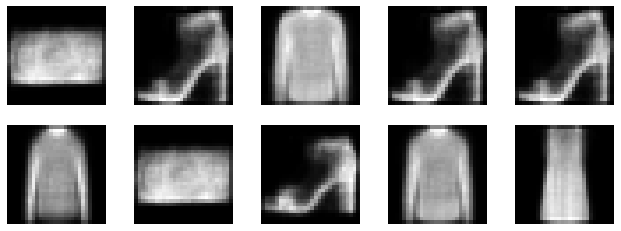

In [ ]:
auto_model.eval()
with torch.inference_mode():
  image1 = image + 0.02*torch.randn_like(image)
  # torch.manual_seed(64)
  # idx = torch.randint(0, len(image1), size = [1]).item()
  # plt.imshow(image1[idx].squeeze(), cmap = 'gray')
  image1 = image1.to(device)
  recreate = auto_model(image1.view(-1, 784))
  # recreate = auto_model.decode(image1.view(-1, 784))

imshow(recreate.view(-1, 1, 28, 28).cpu(), label)

### FC 1 Model t-SNE

In [ ]:
imgs = []
labels = []
num = 0

torch.manual_seed(64)
torch.cuda.manual_seed(64)

with torch.inference_mode():
  for img, label in test_dataloader:
    enimg = fc1_model(img.to(device).view(-1, 784))
    imgs.append(enimg.cpu())
    labels.append(label)
    num += len(img)
    if num >= 1000:
      break

# conver list to tensor
imgs_tensor = torch.cat(imgs)
label_tensor = torch.cat(labels)

imgs_tensor.shape

torch.Size([1024, 10])

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


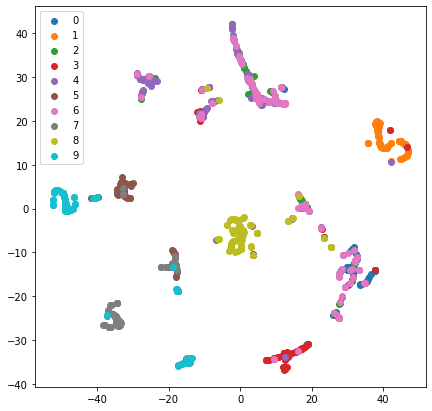

In [ ]:
tsne = TSNE(n_components = 2, random_state = 64)
tsne_model = tsne.fit_transform(imgs_tensor)

fig, ax = plt.subplots(figsize=(7, 7))
for l in np.unique(label_tensor):
    ix = np.where(label_tensor == l)
    ax.scatter(tsne_model[:,0][ix], tsne_model[:,1][ix],  label = l)
ax.legend()
plt.show()

### FC 3

In [ ]:
# train model

torch.manual_seed(64)
torch.cuda.manual_seed(64)
fc3_model = FashionMNISTModelFC3(input_units = 784, output_units = len(class_name), hidden_units = 32).to(device)
fc3_model

# loss and optimizer
# loss
loss_fn = nn.CrossEntropyLoss()

# optimizer
# fc1_optimizer = torch.optim.Adam(params = fc1_model.parameters(), lr = 0.00021)
fc3_optimizer = torch.optim.SGD(params = fc3_model.parameters(), lr = 0.04)

# accuracy
accuracy_fn = MulticlassAccuracy(num_classes = len(class_name)).to(device)

epoches = 10

torch.manual_seed(64)
torch.cuda.manual_seed(64)

train = []
test = []

for epoch in tqdm(range(epoches)):

  train_loss, train_acc = train_loop(model = fc1_model, dataloader = train_dataloader,
                                     loss_fn = loss_fn, optimizer = fc1_optimizer,
                                     accuracy_fn = accuracy_fn, device = device)
  
  test_loss, test_acc = test_loop(model = fc1_model, dataloader = test_dataloader, 
                                  loss_fn = loss_fn, accuracy_fn = accuracy_fn, device = device)
  
  print(f"Epoch: {epoch+1} Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

  train.append(train_loss.item())
  test.append(test_loss.item())


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 1.6177 | Train Acc: 0.69% | Test Loss: 1.6236 | Test Acc: 0.67%
Epoch: 2 Train Loss: 1.6175 | Train Acc: 0.68% | Test Loss: 1.6248 | Test Acc: 0.67%
Epoch: 3 Train Loss: 1.6172 | Train Acc: 0.68% | Test Loss: 1.6236 | Test Acc: 0.67%
Epoch: 4 Train Loss: 1.6169 | Train Acc: 0.68% | Test Loss: 1.6236 | Test Acc: 0.67%
Epoch: 5 Train Loss: 1.6168 | Train Acc: 0.68% | Test Loss: 1.6237 | Test Acc: 0.68%
Epoch: 6 Train Loss: 1.6164 | Train Acc: 0.68% | Test Loss: 1.6230 | Test Acc: 0.67%
Epoch: 7 Train Loss: 1.6162 | Train Acc: 0.68% | Test Loss: 1.6229 | Test Acc: 0.67%
Epoch: 8 Train Loss: 1.6161 | Train Acc: 0.68% | Test Loss: 1.6228 | Test Acc: 0.67%
Epoch: 9 Train Loss: 1.6159 | Train Acc: 0.68% | Test Loss: 1.6238 | Test Acc: 0.67%
Epoch: 10 Train Loss: 1.6159 | Train Acc: 0.68% | Test Loss: 1.6226 | Test Acc: 0.67%


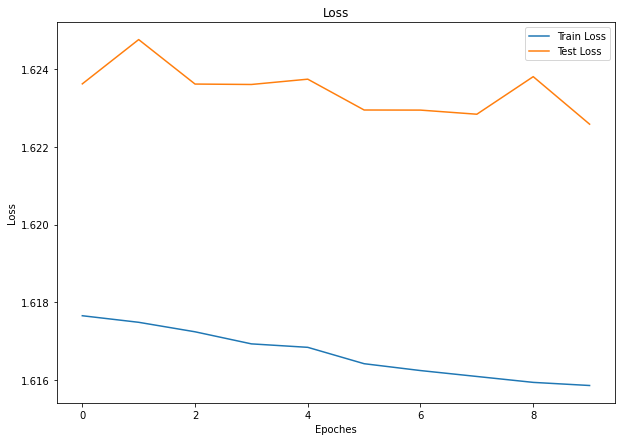

In [ ]:
# loss plot
loss_plot(train, test)

### FC 3 Model Recreation

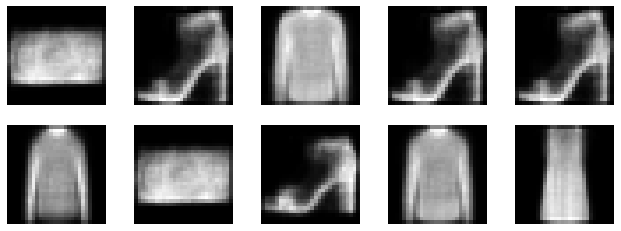

In [ ]:
auto_model.eval()
with torch.inference_mode():
  image1 = image + 0.02*torch.randn_like(image)
  # torch.manual_seed(64)
  # idx = torch.randint(0, len(image1), size = [1]).item()
  # plt.imshow(image1[idx].squeeze(), cmap = 'gray')
  image1 = image1.to(device)
  recreate = auto_model(image1.view(-1, 784))

imshow(recreate.view(-1, 1, 28, 28).cpu(), label)

### FC 3 Model t-SNE

In [ ]:
imgs = []
labels = []
num = 0

torch.manual_seed(64)
torch.cuda.manual_seed(64)

with torch.inference_mode():
  for img, label in test_dataloader:
    enimg = fc3_model(img.to(device).view(-1, 784))
    imgs.append(enimg.cpu())
    labels.append(label)
    num += len(img)
    if num >= 1000:
      break

# conver list to tensor
imgs_tensor = torch.cat(imgs)
label_tensor = torch.cat(labels)

imgs_tensor.shape

torch.Size([1024, 10])

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


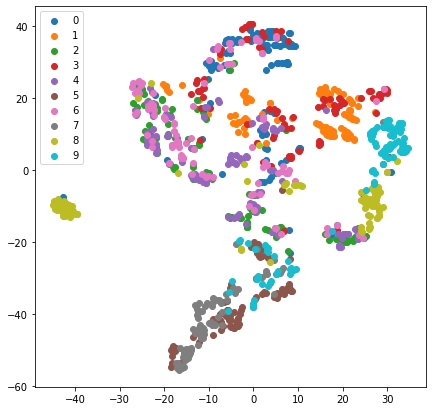

In [ ]:
tsne = TSNE(n_components = 2, random_state = 64)
tsne_model = tsne.fit_transform(imgs_tensor)

fig, ax = plt.subplots(figsize=(7, 7))
for l in np.unique(label_tensor):
    ix = np.where(label_tensor == l)
    ax.scatter(tsne_model[:,0][ix], tsne_model[:,1][ix],  label = l)
ax.legend()
plt.show()

# Recreation of image
Auto encoder, 1 FC model and 3 FC model give same image recreation

# t-SNE
auto-encoder give best t-SNE plot

1 FC give poor t-SNE plot with to uch over laping of data point due to less number of hidden layer 

3 FC give similar like auto encoder t-SNE plot but different distribution and ulti class overlapping